In [21]:
#Librerias a importar
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

In [22]:
#Comenzaremos definiendo una clase comesolo
#esta recibira una matriz de strings, que contendrá un circulo en las entradas validas
#y un cero en las invalidas mas tarde haré alguna herramienta para poder generar estos
#patrones iniciales en forma mas cómoda

#Algo importante es que aquí nos estarémos concentrando en la tabla inglesa, donde solo podemos comer horizontal y verticalmente
#al contrario de lo que ocurre en la versión triangular del juego, donde también podremos comer en diagonal.

class Pegboard:
    def __init__(self, boardSketch):
        self.boardSketch = boardSketch
        n = np.size(boardSketch,0)
        m = np.size(boardSketch,1)
        boardPattern = np.zeros((n,m))
        validPositions = 0
        for i in range(0,n):
            for j in range(0,m):
                if(boardSketch[i,j] == "o"):
                    boardPattern[i,j] = validPositions
                    validPositions += 1
                else:
                    boardPattern[i,j] = -1

        self.boardSketch = boardSketch
        #Guardamos del patrón del tablero
        self.boardPattern = boardPattern
        #Nuestro tablero como tal lo vamos a representar como un arreglo de n entradas donde
        #n es el numero de casillas validas
        self.board  = np.zeros(validPositions)
        self.numberOfHoles = validPositions
        
        #Vamos también a inicializar el arreglo de movimientos
        moves = []
        numberOfMoves = 0
        for i in range(0,n):
            for j in range(0,m):
                
                if(i > 0 and i < n-1 and self.boardSketch[i,j] == "o" and self.boardSketch[i-1,j] == "o" and self.boardSketch[i+1,j] == "o"):
                    #Agregamos el movimiento 
                    moves.append([self.boardPattern[i-1,j], self.boardPattern[i,j], self.boardPattern[i+1,j]])
                    moves.append([self.boardPattern[i+1,j], self.boardPattern[i,j], self.boardPattern[i-1,j]])
                    numberOfMoves += 2
                
                if(j>0 and j < m-1 and self.boardSketch[i,j-1] == "o" and self.boardSketch[i,j] == "o" and self.boardSketch[i,j+1] == "o"):
                    moves.append([self.boardPattern[i,j-1], self.boardPattern[i,j], self.boardPattern[i,j+1]])
                    moves.append([self.boardPattern[i,j+1], self.boardPattern[i,j], self.boardPattern[i,j-1]])
                    numberOfMoves += 2
        
        self.numberOfMoves = numberOfMoves
        self.moves = moves
    
    #Método para inicializar nuestro tablero 
    #con una configuración dada aquí la posición de los pegs 
    #estará dada por un 1 y 0 si no hay
    def initializeBoard(self, initialConfiguration):
        n = np.size(initialConfiguration,0)
        #Verificamos que el arreglo tenga el tamaño adecuado
        if(n != self.numberOfHoles):
            print("La configuración inicial debe ser un arreglo de " + str(self.numberOfHoles) +" elementos ")
            return -1
        
        self.initialConfiguration = initialConfiguration
        self.currentConfiguration = initialConfiguration
    
    def setConfiguration(self, configuration):
        n = np.size(initialConfiguration,0)
        if(n != self.numberOfHoles):
            print("La configuración inicial debe ser un arreglo de " + str(self.numberOfHoles) +" elementos")
            return -1
        self.currentConfiguration = configuration
    
    def isMoveValid(self, m):
        
        p1 = self.currentConfiguration[int(m[0])]
        p2 = self.currentConfiguration[int(m[1])]
        p3 = self.currentConfiguration[int(m[2])]
        if(p1== 1 and p2 == 1 and p3 == 0):
            return True
        else:
            return False
    
    def makeMove(self, m):
        p1 = self.currentConfiguration[int(m[0])]
        p2 = self.currentConfiguration[int(m[1])]
        p3 = self.currentConfiguration[int(m[2])]
        
        if(p1 == 1 and p2 == 1 and p3 == 0):
            self.currentConfiguration[int(m[0])] = 0
            self.currentConfiguration[int(m[1])] = 0
            self.currentConfiguration[int(m[2])] = 1
    
    def makeInverseMove(self, m):
        p1 = self.currentConfiguration[int(m[0])]
        p2 = self.currentConfiguration[int(m[1])]
        p3 = self.currentConfiguration[int(m[2])]
        
        if(p1 == 0 and p2 == 0 and p3 == 1):
            self.currentConfiguration[int(m[0])] = 1
            self.currentConfiguration[int(m[1])] = 1
            self.currentConfiguration[int(m[2])] = 0
    

In [23]:
class PegboardSolitaireSolver2:
    #We will initialize the solver with 
    # a pegboard
    
    def __init__(self, pegboard):
        self.pegboard = pegboard
    
    def computeAMatrix(self):
        moves = self.pegboard.moves
        nMoves = self.pegboard.numberOfMoves
        nHoles = self.pegboard.numberOfHoles
        A = np.zeros((nHoles, nMoves))
        
        for j in range(0,nMoves):
            move = moves[j]
            
            ind1 = int(move[0])
            ind2 = int(move[1])
            ind3 = int(move[2])
            
            A[ind1, j] = 1
            A[ind2, j] = 1
            A[ind3, j] = -1
        
        self.A = A
            
    def setFinalConfiguration(self,finalConfiguration):
        n = np.size(finalConfiguration,0)
        if(n != self.pegboard.numberOfHoles):
            print("Tamaño incorrecto de la configuración final")
            return -1
        else:
            self.finalConfiguration = finalConfiguration

    def computeMoveBounds(self):
        self.unfeasible = False
        nMoves = self.pegboard.numberOfMoves
        moveBounds = np.zeros(nMoves)
        bnd = []
        for i in range(0,nMoves):
            #El número de movimientos puede tomar valores de 0 a infinito
            bnd.append((0,None))
        
        b = np.array(self.pegboard.initialConfiguration) - np.array(self.finalConfiguration)
        
        for i in range(0,nMoves):
            maxTerm = np.zeros(nMoves)
            maxTerm[i] = -1
            #Como esta funcion solo puede minimizar invertimos el signo. 
            opt = linprog(c = maxTerm, A_eq =  self.A, b_eq = b, bounds = bnd,method='interior-point')
            #Almacenamos el valor de optimización 
            if(opt.success):
                moveBounds[i] = np.round(np.abs(opt.x[i]))
            else:
                #Almacenamos una bandera de que el movimiento no conduce a nada. 
                moveBounds[i]  = -1
                self.unfeasible = True
        
        self.moveBounds = moveBounds
    
    #Método para resolver 
    def solve(self): 
        #Checamos si el problema es resoluble, si no lo es entonces simplemente le decimos al usuario
        if(self.unfeasible):
            print("El problema no tiene solución, F")
            return -1
        
        initialPeg = self.pegboard
        rest = sum(initialPeg.initialConfiguration) - sum(self.finalConfiguration)
        self.nSteps = rest
        self.computeMoveBounds()
        self.moveSequence = []
        self.seenConfigurations = {}
        found = self.search(initialPeg, self.finalConfiguration, rest)
        #Vamos a intentar ir almacenando la solución en un hash a ver si funciona
        
        if(not found):
            print("No hay solución")
        else:
            #Guardamos la secuencia de movimientos para poder hacer una animación o algo asi 
            print("Solución guardada")

    #Busqueda usando tracking y cortando ramas en base 
    #a nuestras cotas para el maximo de veces que se va a usar un movimiento
    #dado
    def search(self, startPeg, endConfig, rest):
        
        if(rest  <= 0):
            #Si estamos en esta situación hemos terminado 
            if(startPeg.currentConfiguration == endConfig):
                self.moveSequence.append(startPeg.currentConfiguration.copy())
                print("Success")
                return True
            else:
                print(startPeg.currentConfiguration)
                return False
        
        for i in range(0, startPeg.numberOfMoves):
            move = startPeg.moves[i]
            #Esta parte es el el corte de ramas que sabemos no nos conduciran a nada. 
            if(not startPeg.isMoveValid(move) or self.moveBounds[i] <= 0):
                continue
            #De otra forma vamos a hacer el movimiento y esto implica que restaremos uno a moveBounds
            #porque hay un movimiento menos que podemos hacer.
            self.moveBounds[i] -= 1
            #Aplicamos el movimiento
            startPeg.makeMove(move)
            #Parte recursiva del algoritmo
            #Recordemos para backtracking lo que usamos es DFS
            #que esencialmente es el patrón de buscada que tenemos cuando 
            #usamos recursividad
            
            #Antes vamos a verificar que no hayamos visto ya la configuracion
            configArr = np.array(startPeg.currentConfiguration.copy())
            
            configurationNum = configArr.dot(2**np.arange(configArr.size)[::-1]) 
            
            if(configurationNum in self.seenConfigurations):
                startPeg.makeInverseMove(move)
                self.moveBounds[i] += 1
                continue 
                
            if(self.search(startPeg, endConfig, rest-1) == True):
                #Agregamos el peg a la secuencia de movimientos
                startPeg.makeInverseMove(move)
                self.moveSequence.append(startPeg.currentConfiguration.copy())
                return True
            
            else:
                self.moveBounds[i] += 1
                #Regresamos al estado anterior del tablero
                startPeg.makeInverseMove(move)
                self.seenConfigurations[configurationNum] = configurationNum
        return False
    #Obtenemos la solución, recordemos que tal y como esta estructurado esto tendremos
    #que esta se encuentra al revés (backtracking) así que de hecho hay que obtener en reversa el arreglo
    def getSolution(self):
        moveNumber = len(self.moveSequence)
        print(moveNumber)
        holeNumber = self.pegboard.numberOfHoles
        
        solution = np.zeros((moveNumber, holeNumber))
        
        for i in reversed(range(0, moveNumber)):
            board = self.moveSequence[i]
            solution[moveNumber-i-1,:] = board
        
        return solution
        

In [24]:
#Vamos a hacer la clase para renderizar la secuencia de movimientos 
#de como solo como una animación
class PegboardRenderer:
    
    def __init__(self, pegSolver):
        self.fig, self.ax = plt.subplots()
        #Obtenemos la solución con la cual trabajaremos
        self.moveSequence = pegSolver.getSolution()
        self.pegboard = pegSolver.pegboard
        self.tileSize = 5
        self.holeRadius = self.tileSize/2
        self.tilesWidth = np.size(self.pegboard.boardSketch,1)
        self.tilesHeight = np.size(self.pegboard.boardSketch,0)
        self.colorInvalidPosition = "#3d4752"
        self.colorValidPosition = "#13c2ed"
        self.emptyPegColor = "#6a7375"
        self.filledPegColor = "#e4e9eb"
        
        self.sceneWidth = self.tileSize * self.tilesWidth
        self.sceneHeight = self.tileSize * self.tilesHeight
        
        
    
    def plotPegboardState(self, s):
        boardArray = self.moveSequence[s]
        #El fondo 
        self.ax.clear()
        self.ax.add_patch(patches.Rectangle((0,0), self.sceneWidth, self.sceneHeight, color = self.colorInvalidPosition))
        #Renderizamos el tablero
        offsetY = 0
        for i in range(0, self.tilesHeight):
            offsetX = 0
            for j in range(0, self.tilesWidth):
                xPos = offsetX
                yPos = offsetY
                
                if(self.pegboard.boardSketch[i,j] == "o"):
                    self.ax.add_patch(patches.Rectangle((xPos,yPos), self.tileSize, self.tileSize, color = self.colorValidPosition))
                
                offsetX = offsetX + self.tileSize
            offsetY = offsetY + self.tileSize
        
        offsetY = 0
        for i in range(0, self.tilesHeight):
            offsetX = 0
            for j in range(0, self.tilesWidth):
                index = self.pegboard.boardPattern[i,j]
                if(index != -1):
                    val = boardArray[int(index)]
                    if(val == 1):
                        centerX = offsetX + self.holeRadius
                        centerY = offsetY + self.holeRadius
                        self.ax.add_patch(patches.Circle((centerX, centerY), self.holeRadius, color = self.filledPegColor))
                    elif(val == 0):
                        centerX = offsetX + self.holeRadius
                        centerY = offsetY + self.holeRadius
                        self.ax.add_patch(patches.Circle((centerX, centerY), self.holeRadius, color = self.emptyPegColor))
                offsetX = offsetX + self.tileSize
            offsetY = offsetY + self.tileSize
        self.ax.set_xlim([0,self.sceneWidth])
        self.ax.set_ylim([0,self.sceneHeight])
        self.ax.axis("equal")
    
    def animatePegSolution(self):
        
        #1 frame per second
        speed = 500
        n = np.size(self.moveSequence, 0)
        anim = FuncAnimation(self.fig, self.plotPegboardState, frames = n, interval = speed, blit = False)
        return HTML(anim.to_html5_video())
                                          
        
        
        
        
        

## Pruebas 


In [25]:
#Haremos una prueba con un ejemplo que no deberia tomarle mucho tiempo resolver a nuestro programa
#Creamos un sketch en forma de cruz para el tablero 
sketch = []

for i in range(0,7):
    row = []
    for j in range(0,7):
        if((j >= 2 and j <= 4 ) or (i >= 2 and i <= 4)):
            row.append('o')
        else:
            row.append('-')
    sketch.append(row)
sketch = np.array(sketch)

#Creamos un patrón inicial de prueba 
initialConfiguration = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
finalConfiguration = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
print(sketch)




[['-' '-' 'o' 'o' 'o' '-' '-']
 ['-' '-' 'o' 'o' 'o' '-' '-']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['o' 'o' 'o' 'o' 'o' 'o' 'o']
 ['-' '-' 'o' 'o' 'o' '-' '-']
 ['-' '-' 'o' 'o' 'o' '-' '-']]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Success
Solución guardada
2


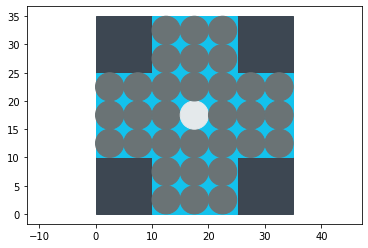

In [26]:
#Creamos un sketch en forma de cruz para el tablero 
sketch = []

for i in range(0,7):
    row = []
    for j in range(0,7):
        if((j >= 2 and j <= 4 ) or (i >= 2 and i <= 4)):
            row.append('o')
        else:
            row.append('-')
    sketch.append(row)
sketch = np.array(sketch)

#Creamos un patrón inicial de prueba 
initialConfiguration = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
finalConfiguration = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
board  = Pegboard(sketch)
board.initializeBoard(initialConfiguration)
pegSolver = PegboardSolitaireSolver2(board)
pegSolver.setFinalConfiguration(finalConfiguration)
pegSolver.computeAMatrix()
pegSolver.computeMoveBounds()
print(pegSolver.moveBounds)
pegSolver.solve()

#Ahora vamos a renderizar el juego 
renderer = PegboardRenderer(pegSolver)
renderer.animatePegSolution()


## Ejemplo chido

In [28]:
initialConfiguration = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
finalConfiguration = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#Inicializamos el tablero con nuestro sketch 
board = Pegboard(sketch)
#Establecemos una configuración inicial
board.initializeBoard(initialConfiguration)
#Ya que hemos inicializado el tablero creamos un Solver 
pegSolver = PegboardSolitaireSolver2(board)
#Tenemos que calcular la matriz inicial 
pegSolver.computeAMatrix()
#Calculamos los bounds para numbero de movimientos
pegSolver.setFinalConfiguration(finalConfiguration)
pegSolver.computeMoveBounds()
pegSolver.solve()

Success
Solución guardada


32


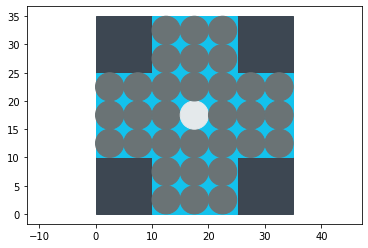

In [29]:
renderer = PegboardRenderer(pegSolver)
renderer.animatePegSolution()

In [15]:
b = np.array([1,0,1,1,1,1,1,1,1,0,1,1,0])
n = b.dot(2**np.arange(b.size)[::-1]) 
print(n)

6134


In [16]:
b = [1,2,3]
np.array(b)

array([1, 2, 3])

In [17]:
b

[1, 2, 3]